## Learning Gradient of a 2-D Nonconvex Function

In [1]:
import sys
import os 
sys.path.append('../')

import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt 
from utils.jac_tests import check_jac_sym
from utils.models import GradNet_M, GradNet_C


gpu_idx = 6
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_idx))
    print("GPU available. Using : " + torch.cuda.get_device_name(gpu_idx))

else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU available. Using : NVIDIA GeForce RTX 2080 Ti


Learning the gradient of the nonconvex function $G(x_1, x_2) = \frac{1}{4}\sin(2\pi x_1)\cos(\pi x_2) + \frac{x_1x_2}{2} - \frac{x_2^2}{2}$

In [2]:
# The nonconvex function
def nonconvex_function(x, y):
    return torch.sin(2*np.pi*x) * torch.cos(np.pi*y)/4 + x*y/2 - (y**2)/2

# The gradient of the nonconvex function
def field(z):
    x = z[:,0]
    y = z[:,1]

    grad_x = 0.5 * np.pi * torch.cos(2*np.pi*x)*torch.cos(np.pi*y) + y/2
    grad_y = -0.25*np.pi*torch.sin(2*np.pi*x)*torch.sin(np.pi*y) + x/2 - y
    return torch.stack([grad_x, grad_y]).T

/home/shreyasc/miniconda3/envs/py311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


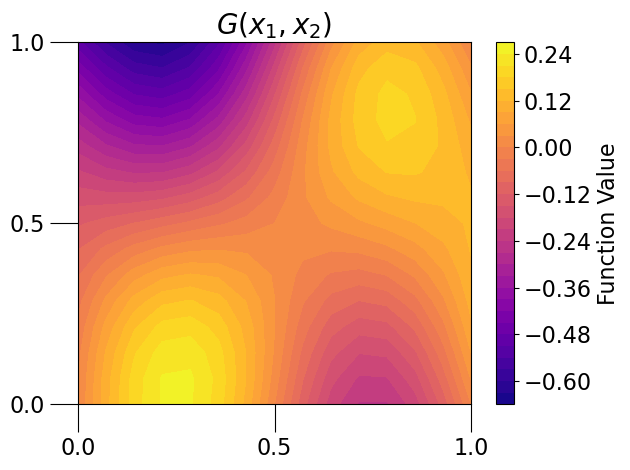

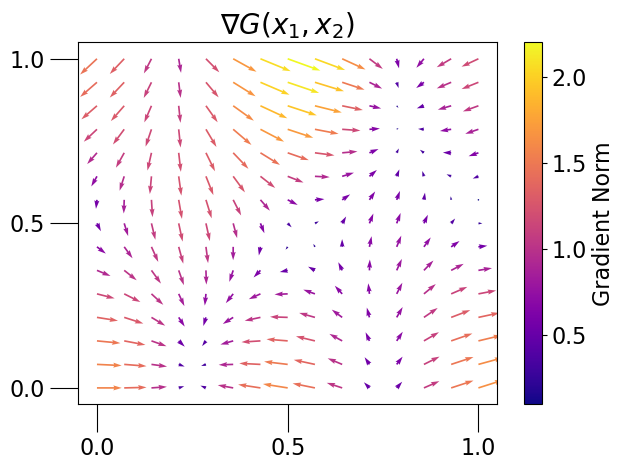

In [3]:
x = torch.linspace(0, 1, 15)
y = torch.linspace(0, 1, 15)

X, Y = torch.meshgrid(x, y)
space = torch.cat([torch.reshape(X,(-1,1)),torch.reshape(Y,(-1,1))],1)
grad = field(space)

label_size = 16
title_size= 20
cmap = 'plasma'
levels = 30

# Create contour plot
plt.figure()
plt.contourf(x, y, nonconvex_function(space[:,0], space[:,1]).view(x.numel(),x.numel()).T, levels=levels, cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.title(r'$G(x_1, x_2)$', size=title_size)
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar()
cbar.set_label('Function Value', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

# Create quiver plot
plt.figure()
p = plt.quiver(space[:,0], space[:,1], grad[:,0], grad[:,1], grad.norm(dim=-1), cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.title(r'$\nabla G(x_1, x_2)$', size=title_size)
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar(p)
cbar.set_label('Gradient Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

### Train GradNets to learn $\nabla G(x_1, x_2)$

In [4]:
## Training parameters 
epochs = 200
lr = 5e-3
train_size = 100000
val_size = 10000
batch_size = 1000
criterion = nn.MSELoss()
num_trials = 5
seed = 42

def train_model(model, data_loader, val_pts, field, save_path):

    # Check if the directory exists, create it if not
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"Directory '{save_path}' created.")
    else:
        print(f"Directory '{save_path}' already exists.")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('Inf')

    for epoch in range(1,epochs+1):
        avg_train_loss = 0
        for i, (x, y) in enumerate(data_loader):
            out = model(x.to(device))
            loss = criterion(out, y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item()
        
        avg_train_loss = avg_train_loss / len(data_loader)
        
        with torch.no_grad():
            val_loss = F.mse_loss(model(val_pts.to(device)), field(val_pts).to(device)).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path+'model.pt')
        
        print("Epoch: ", epoch, "Train Loss: ", avg_train_loss, "Val Loss: ", val_loss)
    
    return

In [5]:
### Train GradNet-C
for trial in range(num_trials):
    torch.manual_seed(seed*trial)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed*trial)
        
    gn_c = GradNet_C(num_layers=4, in_dim=2, embed_dim=7, activation=lambda : nn.Tanh()).to(device) # use learnable activation if desired
    print("GN-C parameters", sum(p.size().numel() for p in gn_c.parameters() if p.requires_grad))
    train_pts = torch.rand(size=(train_size, 2))
    val_pts = torch.rand(size=(val_size, 2))
    data_loader = DataLoader(TensorDataset(train_pts, field(train_pts)), batch_size=batch_size, shuffle=True, num_workers=8)

    print('TRIAL: ', trial)
    train_model(gn_c, data_loader=data_loader, val_pts=val_pts, field=field, save_path='./trained_models/nonconvex/GN-C/trial'+str(trial)+'/')

GN-C parameters 100
TRIAL:  0
Directory './trained_models/nonconvex/GN-C/trial0/' created.
Epoch:  1 Train Loss:  0.42371134787797926 Val Loss:  0.3455802798271179
Epoch:  2 Train Loss:  0.20324401281774043 Val Loss:  0.09337054193019867
Epoch:  3 Train Loss:  0.05452569827437401 Val Loss:  0.033993542194366455
Epoch:  4 Train Loss:  0.023409473001956938 Val Loss:  0.015828177332878113
Epoch:  5 Train Loss:  0.010602419883944093 Val Loss:  0.007279466837644577
Epoch:  6 Train Loss:  0.005792165249586105 Val Loss:  0.004765298217535019
Epoch:  7 Train Loss:  0.0037903460790403186 Val Loss:  0.0032548506278544664
Epoch:  8 Train Loss:  0.002761529239360243 Val Loss:  0.00236612930893898
Epoch:  9 Train Loss:  0.0021798025618772953 Val Loss:  0.0019695127848535776
Epoch:  10 Train Loss:  0.0018811219686176628 Val Loss:  0.0017662885366007686
Epoch:  11 Train Loss:  0.0017052564688492566 Val Loss:  0.0016031550476327538
Epoch:  12 Train Loss:  0.001574522628216073 Val Loss:  0.001491596573

In [6]:
### Train GradNet-M
for trial in range(num_trials):
    torch.manual_seed(seed*trial)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed*trial)
        
    gn_m = GradNet_M(num_modules=4, in_dim=2, embed_dim=7, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired
    print("GN-M parameters", sum(p.size().numel() for p in gn_m.parameters() if p.requires_grad))
    train_pts = torch.rand(size=(train_size, 2))
    val_pts = torch.rand(size=(val_size, 2))
    data_loader = DataLoader(TensorDataset(train_pts, field(train_pts)), batch_size=batch_size, shuffle=True, num_workers=8)

    print('TRIAL: ', trial)
    train_model(gn_m, data_loader=data_loader, val_pts=val_pts, field=field, save_path='./trained_models/nonconvex/GN-M/trial'+str(trial)+'/')

GN-M parameters 94
TRIAL:  0
Directory './trained_models/nonconvex/GN-M/trial0/' created.
Epoch:  1 Train Loss:  0.4899522277712822 Val Loss:  0.40702173113822937
Epoch:  2 Train Loss:  0.3772715303301811 Val Loss:  0.3667164444923401
Epoch:  3 Train Loss:  0.31834974557161333 Val Loss:  0.26090747117996216
Epoch:  4 Train Loss:  0.16890815012156962 Val Loss:  0.08775074779987335
Epoch:  5 Train Loss:  0.056250909753143785 Val Loss:  0.041711900383234024
Epoch:  6 Train Loss:  0.03587690249085426 Val Loss:  0.03184736147522926
Epoch:  7 Train Loss:  0.02927497761324048 Val Loss:  0.027133334428071976
Epoch:  8 Train Loss:  0.025650917924940585 Val Loss:  0.024225255474448204
Epoch:  9 Train Loss:  0.023256783317774535 Val Loss:  0.022173970937728882
Epoch:  10 Train Loss:  0.021555603574961425 Val Loss:  0.020758002996444702
Epoch:  11 Train Loss:  0.020266341883689164 Val Loss:  0.01954367756843567
Epoch:  12 Train Loss:  0.019322977447882295 Val Loss:  0.01878213696181774
Epoch:  13 

### Plot results

In [9]:
# Plot Results
xi = torch.linspace(0, 1, 100)
yi = torch.linspace(0, 1, 100)

Xi, Yi = torch.meshgrid(xi, yi)
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = field(space)

def get_norm_err(model):
    model = model.cpu()
    out = model(space)
    return (targ - out).norm(dim=1).reshape(Xi.shape).T

norm_errs = {'gn_c':[], 'gn_m':[]}

# Load trained models
gn_c = GradNet_C(num_layers=4, in_dim=2, embed_dim=7, activation=lambda : nn.Tanh()).to(device) # use learnable activation if desired
gn_m = GradNet_M(num_modules=4, in_dim=2, embed_dim=7, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired

# Check that jacobians are symmetric
gn_c.load_state_dict(torch.load('./trained_models/nonconvex/GN-C/trial0/model.pt'))
gn_c = gn_c.to(device)
print("gn_c params:", sum(p.size().numel() for p in gn_c.parameters() if p.requires_grad))
check_jac_sym(gn_c, in_dim=2, device=device, domain=[0,1])

gn_m.load_state_dict(torch.load('./trained_models/nonconvex/GN-M/trial0/model.pt'))
gn_m = gn_m.to(device)
print("gn_m params:", sum(p.size().numel() for p in gn_m.parameters() if p.requires_grad))
check_jac_sym(gn_m, in_dim=2, device=device, domain=[0,1])

gn_c params: 100
jacobian symmetric test passed
gn_m params: 94
jacobian symmetric test passed


In [10]:
for t in range(num_trials):
    gn_c.load_state_dict(torch.load('./trained_models/nonconvex/GN-C/trial'+str(t)+'/model.pt'))
    gn_m.load_state_dict(torch.load('./trained_models/nonconvex/GN-M/trial'+str(t)+'/model.pt'))
    norm_errs['gn_c'].append(get_norm_err(gn_c).detach())
    norm_errs['gn_m'].append(get_norm_err(gn_m).detach())

for key in norm_errs.keys():
    errs = norm_errs[key]
    errs = torch.stack(errs, dim=0) #(trials, points, dim)
    errs = torch.mean(torch.square(errs.flatten(start_dim=1)), dim=-1)
    errs = 10*torch.log10(errs)

    print('MSE Statistics Across Trials')
    print('Model: ', key, 'Mean (dB): ', errs.mean().item(), 'Std (dB): ', errs.std().item())    

MSE Statistics Across Trials
Model:  gn_c Mean (dB):  -42.16704559326172 Std (dB):  3.9764413833618164
MSE Statistics Across Trials
Model:  gn_m Mean (dB):  -39.52617263793945 Std (dB):  3.4513840675354004


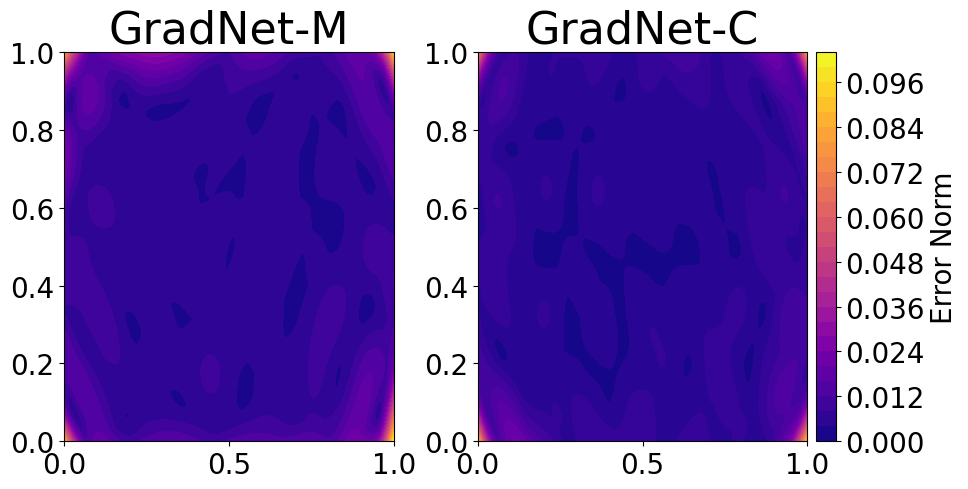

In [12]:
label_size = 20
title_size= 32
cmap = 'plasma'
levels = 30

z_m = torch.stack(norm_errs['gn_m'],dim=0).mean(dim=0)
z_c = torch.stack(norm_errs['gn_c'],dim=0).mean(dim=0)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
cmax = max(z_m.amax(), z_c.max())
gn_m_plt = ax[0].contourf(xi, yi, z_m, levels=levels, cmap=cmap,vmin=0, vmax=cmax)
gn_c_plt = ax[1].contourf(xi, yi, z_c, levels=levels, cmap=cmap,vmin=0, vmax=cmax)

ax[0].set_title('GradNet-M',fontsize=title_size)
ax[1].set_title('GradNet-C',fontsize=title_size)
ax[0].tick_params(axis='both', which='major', labelsize=label_size)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)

plt.tight_layout()
if z_m.amax() > z_c.max():
    cbar = plt.colorbar(gn_m_plt, ax=ax, pad= 0.01)
else:
    cbar = plt.colorbar(gn_c_plt, ax=ax, pad= 0.01)
cbar.set_label('Error Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 